In [2]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

## Exercise 7.1

We first generate 1000 samples from the posterior of the bioassay example.

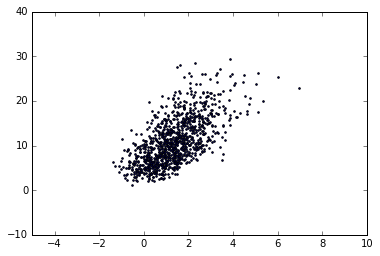

In [162]:
data_x = np.array([-0.86, -0.3, -0.05, 0.73])
data_n = np.array([5, 5, 5, 5])
data_y = np.array([0, 1, 3, 5])
mu = np.array([0, 10])
sigma = np.array([[4, 10], [10, 100]])

def joint(ab, normal_prior=True):
    alpha = ab[:, 0]
    beta = ab[:, 1]
    theta = 1./(1. + np.exp(-(alpha.reshape((1, -1)) + \
                              beta.reshape((1, -1))*x.reshape((-1, 1)))))
    likelihood = theta**y.reshape((-1, 1)) * (1. - theta)**(n - y).reshape((-1, 1))
    joint = np.prod(likelihood, axis=0)
    if normal_prior:
        joint = stats.multivariate_normal.pdf(ab, mu, sigma)*joint
    return joint

def posterior(x, n, y):
    xi = np.arange(-5, 8, 0.1)
    yi = np.arange(-10, 30, 0.1)
    X, Y = np.meshgrid(xi, yi)
    zs = joint(np.concatenate([np.atleast_2d(X.ravel()),
                               np.atleast_2d(Y.ravel())]).T, normal_prior=False)
    Z = zs.reshape(X.shape)
    Z = Z / (Z.sum() * 0.1**2)
    alphaZ = Z.sum(axis=0)
    alphaZ = alphaZ / alphaZ.sum()
    alphas = np.random.choice(xi, size=1000, p=alphaZ)
    alpha_ind = ((alphas + 5.) / 0.1).astype('int')
    betas = np.array([np.random.choice(yi, p=(Z[:, ind] / Z[:, ind].sum())) for ind in alpha_ind])
    alphas = np.random.uniform(-0.05, 0.05, size=1000) + alphas
    betas = np.random.uniform(-0.05, 0.05, size=1000) + betas
    return alphas, betas

alphas, betas = posterior(data_x, data_n, data_y)
plt.scatter(alphas, betas, s=10, marker='.')
plt.xlim([-5, 10])
_ = plt.ylim([-10, 40])

##### AIC
The MLE estimate of $(\alpha,\beta)$ is $(0.8, 7.7)$.
$$
\mathrm{AIC} = -2\log p(y|\hat{\alpha}_{\mathrm{mle}}, \hat{\beta}_{\mathrm{mle}}) + 2k
$$

In [163]:
from scipy.misc import comb
alpha = 0.8
beta = 7.7
theta = 1. / (1. + np.exp(-alpha - beta*x))
log_likelihood = np.log(comb(n, y)) + y*np.log(theta) + (n - y)*np.log(1 - theta)
aic = -2*log_likelihood.sum() + 2*2
print 'elpd_AIC:', log_likelihood.sum() - 2
print 'AIC:', aic

elpd_AIC: -3.98398718949
AIC: 7.96797437898


##### DIC
$$
p_{\mathrm{DIC}} = 2\left(\log p(y|\hat{\alpha}_{\mathrm{Bayes}}, \hat{\beta}_{\mathrm{Bayes}}) - \mathbb{E}_{\mathrm{post}}\log p(y|\alpha, \beta)\right)
$$
$$
\mathrm{\mathrm{DIC}} = -2\log p(y|\hat{\alpha}_{\mathrm{Bayes}}, \hat{\beta}_{\mathrm{Bayes}}) + 2p_{\mathrm{DIC}}
$$

In [164]:
theta = 1. / (1. + np.exp(-alphas.mean() - betas.mean()*x))
term1 = np.log(comb(n, y)) + y*np.log(theta) + (n - y)*np.log(1 - theta)
term1 = term1.sum()
theta = 1. / (1. + np.exp(-alphas.reshape((1, -1)) - \
                          betas.reshape((1, -1))*x.reshape((-1, 1))))
term2 = np.log(comb(n, y)).reshape((-1, 1)) + y.reshape((-1, 1))*np.log(theta) + \
    ((n - y)).reshape((-1, 1))*np.log(1 - theta)
term2 = (term2.sum(axis=0)).mean()
pdic = 2*(term1 - term2)
dic = -2*term1 + 2*pdic
print 'elpd_DIC:', term1 - pdic
print 'DIC:', dic

elpd_DIC: -4.04326006506
DIC: 8.08652013012


##### WAIC
$$
p_{\mathrm{WAIC1}} = 2\sum_{i=1}^n \left(\log(\mathbb{E}_{\mathrm{post}}p(y_i|\alpha, \beta)) - \mathbb{E}_{\mathrm{post}}\log p(y_i|\alpha, \beta)\right)
$$
$$
p_{\mathrm{WAIC2}} = \sum_{i=1}^n \mathrm{var}_{\mathrm{post}}(\log p(y_i|\alpha, \beta))
$$
$$
\mathrm{WAIC} = -2\sum_{i=1}^n \log \mathbb{E}_{\mathrm{post}} p(y_i|\alpha,\beta) + 2p_{\mathrm{WAIC}}
$$

In [165]:
theta = 1. / (1. + np.exp(-alphas.reshape((1, -1)) - \
                          betas.reshape((1, -1))*x.reshape((-1, 1))))
ll = np.log(comb(n, y)).reshape((-1, 1)) + y.reshape((-1, 1))*np.log(theta) + \
    ((n - y)).reshape((-1, 1))*np.log(1 - theta)
def logmeanexp(z, axis=0):
    z_max = z.max(axis=axis, keepdims=True)
    return np.log(np.mean(np.exp(z - z_max), axis=axis)) + z_max.mean(axis=axis)
lppd = logmeanexp(ll, axis=1).sum()
term1 = lppd
term2 = ll.mean(axis=1).sum()
pwaic1 = 2*(term1 - term2)
waic1 = -2*term1 + 2*pwaic1
print 'elpd_WAIC1:', term1 - pwaic1
print 'WAIC1:', waic1
pwaic2 = ll.var(axis=1).sum()
waic2 = -2*term1 + 2*pwaic2
print 'elpd_WAIC2:', term1 - pwaic2
print 'WAIC2:', waic2

elpd_WAIC1: -3.43514091731
WAIC1: 6.87028183462
elpd_WAIC2: -3.85580360372
WAIC2: 7.71160720744


##### cross-validation
Because the data size is small, we should use the bias correction here.

In [166]:
lls = []
lppds = []
for i in xrange(x.shape[0]):
    _x = np.hstack((x[:i], x[(i+1):]))
    _n = np.hstack((n[:i], n[(i+1):]))
    _y = np.hstack((y[:i], y[(i+1):]))
    alphas, betas = posterior(_x, _n, _y)
    theta = 1. / (1. + np.exp(-alphas - betas*x[i]))
    ll = np.log(comb(n[i], y[i])) + y[i]*np.log(theta) + \
        (n[i] - y[i])*np.log(1 - theta)
    theta = 1. / (1. + np.exp(-alphas.reshape((1, -1)) - 
                              betas.reshape((1, -1))*_x.reshape((-1, 1))))
    lppd_ni = np.log(comb(_n, _y)).reshape((-1, 1)) + _y.reshape((-1, 1))*np.log(theta) + \
        ((_n - _y)).reshape((-1, 1))*np.log(1 - theta)
    lppds.append(logmeanexp(lppd_ni, axis=1).sum())
    lls.append(logmeanexp(ll, axis=0))
lls = np.array(lls)
lppds = np.array(lppds)
lppd_loo_cv = lls.sum()
print 'lppd_cloo_cv:', lppd_loo_cv + (lppd - lppds.mean())
print 'LOO-CV:', -2*(lppd_loo_cv + (lppd - lppds.mean()))

lppd_cloo_cv: -3.44686663141
LOO-CV: 6.89373326283


## Exercise 7.2

Too long to rewrite here. The main idea is to calculate the bias between two different order of doing expectation. One is $\mathbb{E}_{y}\mathbb{E}_{\theta_{Bayes}}$, where $\theta_{Bayes}$ depends on $y$, as the expected predictive value. The other is $\mathbb{E}_{\hat{\theta}_{Bayes}}\mathbb{E}_{y|\theta_{Bayes}=\hat{\theta}_{Bayes}}$, which is the value before correction.


## Exercise 7.3

## Exercise 7.4

#### (a)
The Bayes Factor
$$
\begin{aligned}
p(y|H_2) &= \int p(y|\theta_2)p(\theta_2|H_2)\;d\theta_2 \\
&= \int \left[\prod_{j=1}^J\mathcal{N}(y_j|\theta, \sigma_j^2)\right]\mathcal{N}(\theta|0, A^2)\;d\theta \\
&= \frac{1}{\sqrt{2\pi}A} \prod_{j=1}^J\frac{1}{\sqrt{2\pi}\sigma_j} \left[\frac{2\pi}{\sum_{j=1}^J\frac{1}{\sigma_j^2} + \frac{1}{A^2}}\right]^{1/2} \exp\left[\frac{(\sum_{j=1}^J \frac{y_j}{\sigma_j^2})^2}{2(\sum_{j=1}^J\frac{1}{\sigma_j^2} + \frac{1}{A^2})} - \sum_{j=1}^J\frac{y_j^2}{2\sigma_j^2} \right]
\end{aligned}
$$
$$
\begin{aligned}
p(y|H_1) &= \int p(y|\theta_1)p(\theta_1|H_1)\;d\theta_1 \\
&= \int \prod_{j=1}^J\left[\mathcal{N}(y_j|\theta_j, \sigma_j^2)\mathcal{N}(\theta_j|0, A^2)\right]\;d\theta_1\dots\theta_J \\
&= \left[\frac{1}{\sqrt{2\pi}A}\right]^J \prod_{j=1}^J\frac{1}{\sqrt{2\pi}\sigma_j} \prod_{j=1}^J\left[\frac{2\pi}{\frac{1}{\sigma_j^2} + \frac{1}{A^2}}\right]^{1/2} \prod_{j=1}^J \exp\left[\frac{(\frac{y_j}{\sigma_j^2})^2}{2(\frac{1}{\sigma^2} + \frac{1}{A^2})} - \frac{y_j^2}{2\sigma_j^2}\right]
\end{aligned}
$$
$$
\begin{aligned}
\frac{p(y|H_2)}{p(y|H_1)} &= \frac{\left[\frac{2\pi}{\sum_{j=1}^J\frac{1}{\sigma_j^2} + \frac{1}{A^2}}\right]^{1/2} \exp\left[\frac{(\sum_{j=1}^J \frac{y_j}{\sigma_j^2})^2}{2(\sum_{j=1}^J\frac{1}{\sigma_j^2} + \frac{1}{A^2})} \right]}{\left[\frac{1}{\sqrt{2\pi}A}\right]^{J-1} \prod_{j=1}^J\left[\frac{2\pi}{\frac{1}{\sigma_j^2} + \frac{1}{A^2}}\right]^{1/2} \prod_{j=1}^J \exp\left[\frac{(\frac{y_j}{\sigma_j^2})^2}{2(\frac{1}{\sigma_j^2} + \frac{1}{A^2})} \right]}
\end{aligned}
$$

#### (b)
Let $A \to \infty$, then
$$
\frac{p(y|H_2)}{p(y|H_1)} \propto A^{J-1} \to \infty
$$
when $J > 1$

#### (c)

Let
$$
\bar{y} = \frac{1}{J}\sum_{j=1}^J y_j
$$
$$
s^2 = \frac{1}{J-1}\sum_{j=1}^J(y_j - \bar{y})^2
$$
so
$$
\sum_{j=1}y_j^2 = (s^2 + \bar{y}^2)J - s^2
$$
And $\sigma_1 = \sigma_2 = \dots = \sigma_J$
$$
\frac{p(y|H_2)}{p(y|H_1)} = \frac{\exp\left[\frac{(\frac{J\bar{y}}{\sigma^2})^2}{2(\frac{J}{\sigma^2} + \frac{1}{A^2})}\right](1 + \frac{A^2}{\sigma^2})^{J/2}}{\exp\left[\frac{\frac{(s^2+\bar{y}^2)J - s^2}{\sigma^4}}{2(\frac{1}{\sigma^2} + \frac{1}{A^2})}\right](1 + \frac{A^2}{\sigma^2}J)^{1/2}}
$$
so when $J \to \infty$, the asymptotic behavior heavily depends on other parameters, that is, the scale of the 2 exps.